<a href="https://colab.research.google.com/github/imcatta/cats_vs_dogs_classification/blob/master/cats_vs_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cats vs Dogs classification

*Per realizzare questo elaborato ho preso spunto dal final assignment della summer school sul Deep Learning a cui ho partecipato presso l'Università di Odense [https://imada.sdu.dk/~roettger/teaching/2019_summer_school.php](https://imada.sdu.dk/~roettger/teaching/2019_summer_school.php)*

L'obiettivo di questo elaborato è quello di costruire un modello per la classificazione di immagini di cani e gatti, avendo a disposizione un dataset piccolo (3000 immagini). 

Verranno esplorati i seguenti approcci:
*   Addestramento di un piccolo modello costruito da zero
*   Utilizzo di bottleneck features di una rete pre-addestrata

Per l'implementazione verrà utilizzato il framework [Keras](https://keras.io/), con [Tensorflow](https://www.tensorflow.org/) come backend.


Per prima scarichiamo e scompattiamo il dataset

In [1]:
!wget https://github.com/imcatta/cats_vs_dogs_classification/raw/master/dataset_catdog.zip
!unzip dataset_catdog.zip
!mv dataset raw_dataset

--2019-10-13 13:17:56--  https://github.com/imcatta/cats_vs_dogs_classification/raw/master/dataset_catdog.zip
Resolving github.com (github.com)... 140.82.118.3
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/imcatta/cats_vs_dogs_classification/master/dataset_catdog.zip [following]
--2019-10-13 13:17:56--  https://media.githubusercontent.com/media/imcatta/cats_vs_dogs_classification/master/dataset_catdog.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68820953 (66M) [application/zip]
Saving to: ‘dataset_catdog.zip.1’

dataset_catdog.zip. 100%[===================>]  65.63M   302MB/s    in 0.2s    

2019-10-13 13:17:58 (302 MB/s) - 

Ora suddiviamo le immagini nel *train set*, *validation set* e *test set*. Avendo a disposizione un dataset piccolo (3000 samples) è necessario trovare una suddivisione che permetta di massimizzare il numero di samples utilizzati per il train del modello, avendo comunque a disposizione un numero ragionevole di samples per la validazione e test. Dediamo quindi di usare una suddivisione 80/10/10, ossia 2400/300/300 samples.
Andiamo quindi a posizionare i file in cartelle secondo questo schema:


```
dataset/
├── test/
│   ├── cats
│   ├── dogs
├── train/
│   ├── cats
│   ├── dogs
├── validation/
│   ├── cats
│   ├── dogs

```

**Nota 1**: Le immagini vengono mischiate in maniera random prima di essere posizionate nelle cartelle; in questo modo si "rompono" eventuali pattern presenti nel dataset di partenza per evitare bias nel nostro modello.

**Nota 2**: Si è scelto di utilizzare anche un test set perché è esplicitamente richiesto nell'assignment che ha ispirato questo elaborato.

In [0]:
import random
import os
from shutil import copyfile
import numpy as np


# create dirs
dataset_home = 'dataset'
subdirs = ['train', 'test', 'validation']
for subdir in subdirs:
    # create label subdirs
    labeldirs = ['dogs', 'cats']
    for labldir in labeldirs:
        newdir = os.path.join(dataset_home, subdir, labldir)
        os.makedirs(newdir, exist_ok=True)

src_directory = 'raw_dataset'

raw_dataset_filenames =  [f for f in os.listdir(src_directory) if os.path.isfile(os.path.join(src_directory, f))]
raw_dataset_len = len(raw_dataset_filenames)
np.random.shuffle(raw_dataset_filenames)

n_train_samples = int(0.8 * raw_dataset_len)
n_validation_samples = int(0.1 * raw_dataset_len)
n_test_samples = int(0.1 * raw_dataset_len)

training_set = raw_dataset_filenames[:n_train_samples]
validation_set = raw_dataset_filenames[n_train_samples:n_train_samples+n_validation_samples]
test_set = raw_dataset_filenames[n_train_samples+n_validation_samples:]

for filenames, dest_dir in ((training_set, 'train'), (validation_set, 'validation'), (test_set, 'test')):
  for filename in filenames:
    if filename.startswith('cat'):
      dst = os.path.join(dataset_home, dest_dir, 'cats', filename)
    elif filename.startswith('dog'):
      dst = os.path.join(dataset_home, dest_dir, 'dogs', filename)
    else:
      assert(False)
          
    copyfile(os.path.join(src_directory, filename), dst)


### Data Augmentation
Per poter ottenere il massimo dal nostro piccolo dataset, lo "**aumenteremo**" attraverso delle **trasformazioni random**. In questo modo in fase di training il nostro modello non vedrà mai due volte la stessa immagine. Questo favorisce la riduzione dell'overfitting e in aiuta il nostro modello a generalizzare meglio.

Per effettuare queste trasformazioni utilizziamo la classe `keras.preprocessing.image.ImageDataGenerator`. Questa classe ci permette di:

*   Eseguire trasformazioni random e operazioni di normalizzazione sulle immagini
*   Istanziare generatori di immagini aumentate e (con le rispettive label) attraverso i metodi `.flow(data, labels)` e `.flow_from_directory(directory)`




**Nota**: Utilizziamo la data augmentation solo sul dataset di train. Il motivo è che lo scopo della validazione e del test è quello di stimare l'errore che il nostro modello avrà nella realtà, quindi non ha senso modificare tali immagini.

In [3]:
from keras.preprocessing.image import ImageDataGenerator

GENERATOR_BATCH_SIZE = 64
TARGET_SIZE = (150, 150)

#Train data augmentation. 
train_datagen = ImageDataGenerator( 
    brightness_range=[0.4, 1.0], # the impact of random brightness modifications appeared to be the most relevant among the ones tested
    width_shift_range=0.2, # random horizontal shift of pixels
    height_shift_range=0.2, # random vertical shift of pixels
    horizontal_flip=True, # random horizontal flip of pictures (vertical flip decreases performances)
    rescale=1.0/255, # RGB channels rescaled to be between 0 and 1
    zoom_range=0.2
) 
# Training data loading and rescaling                                    
train_generator = train_datagen.flow_from_directory(
    directory=os.path.join(dataset_home, 'train'),
    target_size=TARGET_SIZE, # requested input shape of pictures
    batch_size=GENERATOR_BATCH_SIZE,
    class_mode='binary' # binary output: cat or dog
)

# Validation data loading and rescaling
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(
    directory=os.path.join(dataset_home, 'validation'),
    target_size=TARGET_SIZE,
    batch_size=GENERATOR_BATCH_SIZE,
    class_mode='binary'
)

# Test data loading and rescaling
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    directory=os.path.join(dataset_home, 'test'),
    target_size=TARGET_SIZE,
    batch_size=GENERATOR_BATCH_SIZE,
    class_mode='binary'
)


Using TensorFlow backend.


Found 2400 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


Visualizziamo un esempio del risultato delle operazioni di data augmentation.

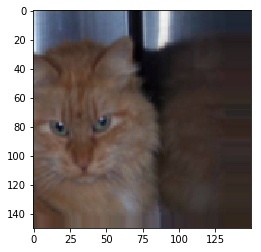

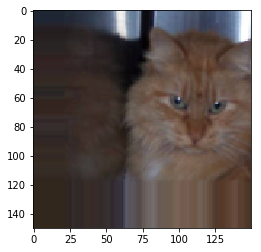

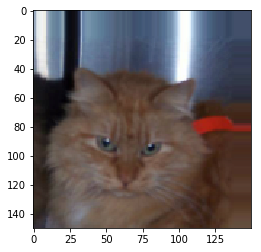

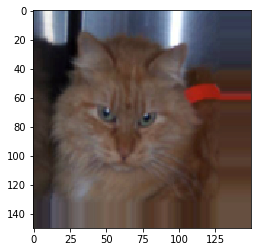

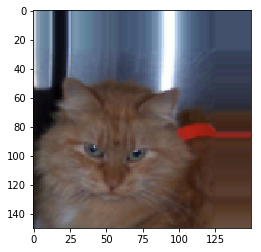

In [4]:
%matplotlib inline

import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img


img_filename = os.listdir(os.path.join(dataset_home, 'train', 'cats'))[5]
img_path = os.path.join(dataset_home, 'train', 'cats', img_filename)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in train_datagen.flow(x, batch_size=1):
  plt.figure(i)
  img = array_to_img(batch[0])
  imgplot = plt.imshow(img)
  i += 1
  if i % 5 == 0:
    break

## Approccio 1: modello piccolo costruito da zero
Un tool adatto per la classificazione di immagini è una **rete convoluzionale**. Abbiamo deciso quindi di implementarne una.

Poiché abbiamo pochi samples, il nostro principale problema è l'**overfitting**. L'overfitting avviene quando il modello viene allenato con un numero troppo piccolo di dati rispetto alla sua "complessità"; ciò comporta  problemi di generalizzazione quando il nostro modello è esposto a casi reali.

La **data augmentation** è uno strumento utile per prevenire l'overfitting. ma spesso non è sufficiente poiché i sample "aumentati" sono comunque fortemente correlati. Per combattere l'overfitting dobbiamo concentrarci sulla **capacità entropica** del modello, ossia quanto è complessa la relazione che il modello può rappresentare. Un modello che può rappresentare relazioni complesse potenzialemente può essere più accurato perché può estrarre più features, allo stesso tempo però corre anche il rischio di apprendere feature irrilevanti. Allo stesso tempo un modello semplice può acquisire un numero minore di feature; di conseguenza tenderà a concentrarsi solo sulle feature più rilevanti presenti nel dataset, che verosimilmente sono le feature realmente più rilevanti e che quindi aiutano a generalizzare meglio.
In altre parole affrontare questo problema significa andare alla ricerca un **bias-variance tradeoff**.


Ci sono diversi modi per modulare la capacità entropica del modello. Il principale è la scelta della struttura del modello, come ad esempio il numero di layer e il numero di parametri del modello. Un altro modo è utilizzare tecniche di regolarizzazione, come ad esempio le regolarizzazioni L1 e L2 che impongono al modello di scegliere parametri più piccoli in valore assoluto.

\

Nel nostro caso abbiamo scelto di costruire una rete convoluzionale con pochi layer, di utilizzare la data augmentation e il **dropout**. Il dropout è un altro strumento utlizzato per ridurre l'overfitting. Consiste nell'ignorare alcune unità (neuroni) scelte a caso con probabilità $p$ durante la fase di addestramento. Per "ignorare" si intende dire che queste unità non vengono prese in considerazione durante un particolare passaggio forward o backward. Ciò evita quindi che un layer veda due volte gli stessi identici pattern,  sfruttando quindi un'idea analoga a quella alla base della data augmentation (si possono vedere la data augmentation e il dropout come strumenti che "rompono" la correlazione random presente nei dati di train).

Il codice che segue costruisce il nostro modello. Dopo svariati tentativi, abbiamo osservato che il miglior risultato si ottiene con **4 layer convoluzionali**, ognuno dei quali seguito da un **max pooling**. Come funzione di attivazione abbiamo utilizzato **ReLU**, la funzione di attivazione più comunemente utilizzata per le CNNs. ReLU è spesso una buona scelta, perché è semplice da computare, converge velocemente e genera modelli sparsi. In coda abbiamo un solo layer **dense** seguito da una sigmoide su cui è applicato un **dropout**. Durante la fase di sperimentazione abbiamo verificato che curiosamente in questo modello l'uso delle regolarizzazioni L1 e L2 produce un lieve calo delle performance; abbiamo quindi deciso di non includerle nel modello finale. Come ottimizzatore abbiamo scelto **Adam** (Adaptive moment estimation). Gli autori definiscono Adam come ottimizzatore che unisce i vantaggi di Adagrad (Adaptive Gradient Algorithm) con RMSProp (Root Mean Square Propagation). A differenza di RMSProp, invece di adattare il learning in base al momento primo (la media) del gradiente, Adam utilizza anche i momenti secondi (la varianza non centrata). Abbiamo inoltre verificato che inizializzare i pesi con l'**inizializzazione Xavier & He Normal** comporta una velocità di convergenza maggiore e complessivamente un modello migliore se paragonato all'inizializzazione random. Abbiamo inoltre utilizzato la tecnica **early stopping** per fermare con lo scopo di evitare overfitting, utilizzando l'accuracy come metrica di valutazione.


In [5]:
from keras.layers import Dense, Conv2D, Dropout, MaxPooling2D, Flatten
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit_generator(
    train_generator, 
    epochs=200, 
    validation_data=validation_generator,
    callbacks=[
        ModelCheckpoint('model1_best.h5', monitor='val_acc', mode='max', verbose=1),
        EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=20)
    ]
)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 64)        0         

Il training è stato eseguito nell'ambiente Google Colab, utilizzando una GPU Tesla K80. 

In [14]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 610706657637248438, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 7539249294069806786
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 10158317105588675560
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11330115994
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10657694979301160545
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

Dopo ~30 minuti il training termina. Il miglior modello lo si è ottenuto all'epoca 37, con una validation accuracy di 0.85. Non è un brutto risultato considerata la dimensione del dataset a disposizione.

Plottiamo ora l'evoluzione di accuracy e loss all'avanzare dell'addestramento

In [0]:
import matplotlib.pyplot as plt

def plot_history(history):
  # Plot training & validation accuracy values
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()
  

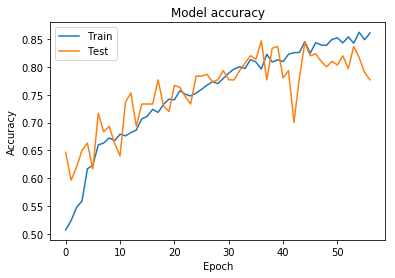

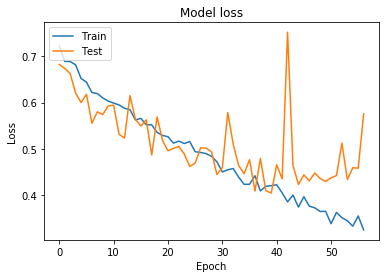

In [9]:
plot_history(history)

DNotiamo che la varianza dell'accuratezza in validazione è abbastanza grande. Questo è dovuto sia al fatto che l'accuratezza è una metrica a grande varianza e sia perché stiamo usando solo 300 samples per la validazione. Una buona strategia di validazione in questi casi è utilizzare la **k-fold cross-validation**. Abbiamo deciso però di non utilizzarla perché i tempi di training sarebbero diventati insostebili.


## Approccio 2: bottleneck features con una rete pre-addestrata
Un approccio più raffinato è quello di sfruttare una rete pre-addestrata su un set di dati di grandi dimensioni. Una rete di questo tipo ha già appreso le feature utili per la maggior parte dei problemi di *artificial vision* e sftuttare tali feature ci consente di raggiungere una migliore accuratezza rispetto a qualsiasi metodo che si basa solo sui dati disponibili nel nostro dataset.

Useremo l'architettura **VGG16**, pre-addestrata sul set di dati **ImageNet**. Poiché il set di dati ImageNet contiene diverse classi "cat" (gatto persiano, gatto siamese ...) e molte classi "dog" tra le sue 1000 classi complessive, questo modello ha già appreso le feature rilevanti per il nostro problema di classificazione. È possibile che la semplice regolazione delle previsioni di softmax del modello sui nostri dati piuttosto che le caratteristiche del collo di bottiglia sia sufficiente per risolvere il problema di classificazione dei nostri cani contro i gatti estremamente bene. Tuttavia, il metodo che presentiamo qui è più probabile che si generalizzi bene a una gamma più ampia di problemi, inclusi i problemi con le classi assenti da ImageNet.

Ecco come si presenta l'architettura VGG16:
![VGG16 architecture](https://blog.keras.io/img/imgclf/vgg16_original.png)

La nostra strategia è la seguente: istanziamo solo la parte convoluzionale del modello, ossia dall'inizio sino ai layer fully-connected. Eseguiamo quindi questa parte del modello sui nostri dati di training e validazione, registrando l'output (le "bottleneck features" del modello VGG16) in due array numpy. Successivamente addestreremo un piccolo modello fully-connected al di sopra di tali feature.

Il motivo per cui stiamo memorizzando le feature offline piuttosto che congelare i layer convoluzionali di VGG16 e quindi aggiungere il nostro modello fully-connected direttamente sopra i layer convoluzionali è l'efficienza computazionale. L'esecuzione di VGG16 è costosa: in questo modo riusciamo ad eseguirlo una volta sola per poi addestrare solo il nostro piccolo modello. 

**Nota**: Per poter utilizzare questa ottimizzazione dobbiamo rinunciare alla possibilità di utilizzare la data augmentation.

In [31]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications

# dimensions of our images.
img_width, img_height = 150, 150

top_model_weights_path = 'bottleneck_fc_model.h5'
batch_size = 20 


def save_bottlebeck_features():
    datagen = ImageDataGenerator(rescale=1. / 255)

    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')

    generator = datagen.flow_from_directory(
        os.path.join(dataset_home, 'train'),
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_train = model.predict_generator(
        generator, n_train_samples // batch_size)
    np.save('bottleneck_features_train.npy', bottleneck_features_train)

    generator = datagen.flow_from_directory(
        os.path.join(dataset_home, 'validation'),
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_validation = model.predict_generator(
        generator, n_validation_samples // batch_size)
    np.save('bottleneck_features_validation.npy', bottleneck_features_validation)


def train_top_model():
    train_data = np.load('bottleneck_features_train.npy')
    train_labels = np.array([0] * len(os.listdir('dataset/train/cats')) + [1] * len(os.listdir('dataset/train/dogs')))

    validation_data = np.load('bottleneck_features_validation.npy')
    validation_labels = np.array([0] * len(os.listdir('dataset/validation/cats')) + [1] * len(os.listdir('dataset/validation/dogs')))

    print(len(os.listdir('dataset/validation/cats')) + len(os.listdir('dataset/validation/dogs')))

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model.fit(train_data, train_labels,
              epochs=200,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels),
              callbacks=[
                  ModelCheckpoint('model2_best.h5', monitor='val_acc', mode='max', verbose=1),
                  EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=20)
              ])


save_bottlebeck_features()
history = train_top_model()

Found 2400 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
300
Train on 2400 samples, validate on 300 samples
Epoch 1/200
2400/2400 [==============================] - 3s 1ms/step - loss: 0.4595 - acc: 0.7996 - val_loss: 0.2793 - val_acc: 0.8733

Epoch 00001: saving model to model2_best.h5
Epoch 2/200
2400/2400 [==============================] - 1s 431us/step - loss: 0.2711 - acc: 0.8825 - val_loss: 0.2203 - val_acc: 0.9000

Epoch 00002: saving model to model2_best.h5
Epoch 3/200
2400/2400 [==============================] - 1s 418us/step - loss: 0.2129 - acc: 0.9167 - val_loss: 0.2080 - val_acc: 0.9000

Epoch 00003: saving model to model2_best.h5
Epoch 4/200
2400/2400 [==============================] - 1s 419us/step - loss: 0.1686 - acc: 0.9317 - val_loss: 0.1956 - val_acc: 0.8933

Epoch 00004: saving model to model2_best.h5
Epoch 5/200
2400/2400 [==============================] - 1s 431us/step - loss: 0.1582 - acc: 0.9367 - val_loss: 0.1942 - val_acc: 0.9100

Ep

In questo caso l'addestramento è molto più veloce (~1 minuto). Si arriva ad una validation accuracy di 0.92. Come era lecito attendersi abbiamo ottenuto un miglioramento significativo rispetto al moldello precedente (+0.05). È interessante notare che il modello migliore è stato ottenuto all'epoca 17, che è significativamente inferiore rispetto al numero di epoche necessarie per il modello creato da zero. Ciò ha senso,, perché che di fatto stiamo ottimizzando solo una piccola rete con un solo layer fully-connected.

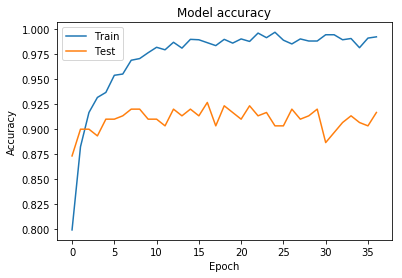

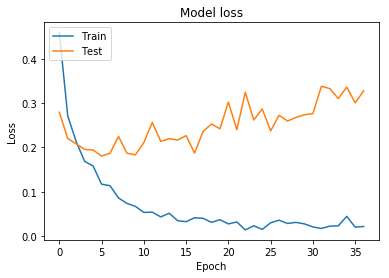

In [32]:
plot_history(history)

Infine valutiamo le prestazioni sul test set, per avere una stima delle prestazioni dei nostri modelli nel mondo reale.

In [20]:
from keras.models import load_model

def test_model1(model):
  batch_size = 20

    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        'dataset/test',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False
    )

    n_samples = len(test_generator.filenames)
    return model.evaluate_generator(test_generator)

test_model1(load_model('model1_best.h5'))

Found 300 images belonging to 2 classes.


[0.3961504782239596, 0.8399999936421713]

In [33]:
def test_model2(model):
  batch_size = 20

  test_datagen = ImageDataGenerator(rescale=1./255)
  test_generator = test_datagen.flow_from_directory(
      'dataset/test',
      target_size=(150, 150),
      batch_size=batch_size,
      class_mode='binary',
      shuffle=False
  )
  n_samples = len(test_generator.filenames)
  
  vgg16 = applications.VGG16(include_top=False, weights='imagenet')
  bottleneck_features_test = vgg16.predict_generator(
        test_generator, n_samples // batch_size)
  test_labels = np.array([0] * len(os.listdir('dataset/test/cats')) + [1] * len(os.listdir('dataset/test/dogs')))  
  return model.evaluate(x=bottleneck_features_test, y=test_labels)

test_model2(load_model('model2_best.h5'))

Found 300 images belonging to 2 classes.
300/300 [==============================] - 1s 3ms/step


[0.6193289764722189, 0.88]

Anche qui abbiamo ottenuto dei risultati interessanti. L'accuracy sul test set per il primo modello considerato è di 0.84, praticamente identitica a quella ottenuta sul validation set (0.85).

Con il secondo modello abbiamo ottenuto una test accuracy pary a 0.88. Come era lecito attendersi con il second modello abbiamo ottenuto sì una test accuracy migliore rispetto a quella ottenuta con il primo modello (+0.04), ma abbiamo anche un importante discostamento con l'accuracy sul validation set (-0.4). Ciò può significare che il nostro secondo modello sta overfittando. A questo punto una buona idea potrebbe essere quella di intervenire con tecniche di regolarizzazione più spinte. Detto ciò, poiché abbiamo a disposizione un test set abbastanza piccolo (300 samples), non possiamo escludere che la differenza riscontrata tra la validation accuracy e la test accuracy sia legata semplicemente a correlazioni presenti nei set considerati.